In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

torch.set_grad_enabled(False);

2.6.0 False


In [2]:
import torchvision.transforms as T

# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [3]:
def filter_bboxes_from_outputs(outputs,
                               threshold=0.7):

  # keep only predictions with confidence above threshold
  probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  probas_to_keep = probas[keep]

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

  return probas_to_keep, bboxes_scaled

In [12]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

In [13]:
import matplotlib.pyplot as plt

def plot_results(pil_img, prob=None, boxes=None):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if prob is not None and boxes is not None:
      for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=c, linewidth=3))
          cl = p.argmax()
          text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [14]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

Using cache found in /Users/orcanon/.cache/torch/hub/facebookresearch_detr_main
/Users/orcanon/.conda/envs/python3-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/orcanon/.conda/envs/python3-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
from PIL import Image
from pathlib import Path
import requests

img_path = Path("AU-AIR/images") / "frame_20190905143505_x_0001047.jpg"

im = Image.open(img_path)      # returns a PIL.Image object
im = im.convert("RGB")         # optional: be explicit about mode
im.show()                      # quick visual check

In [16]:
# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

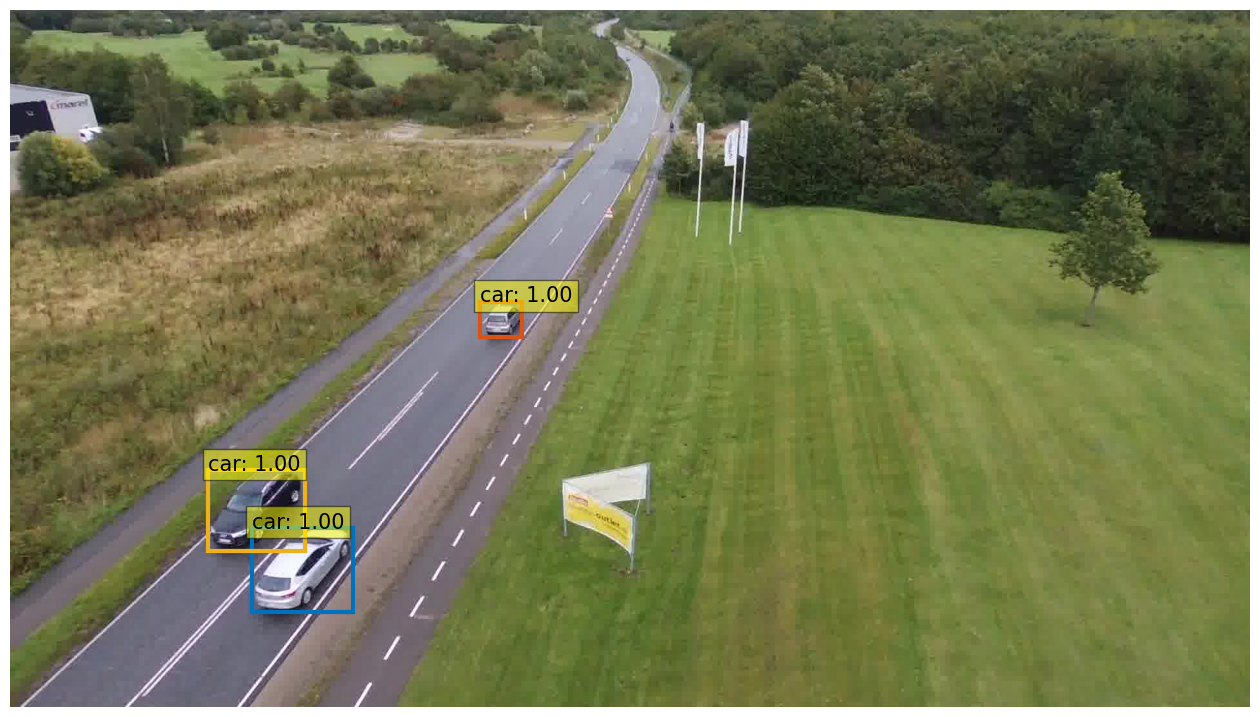

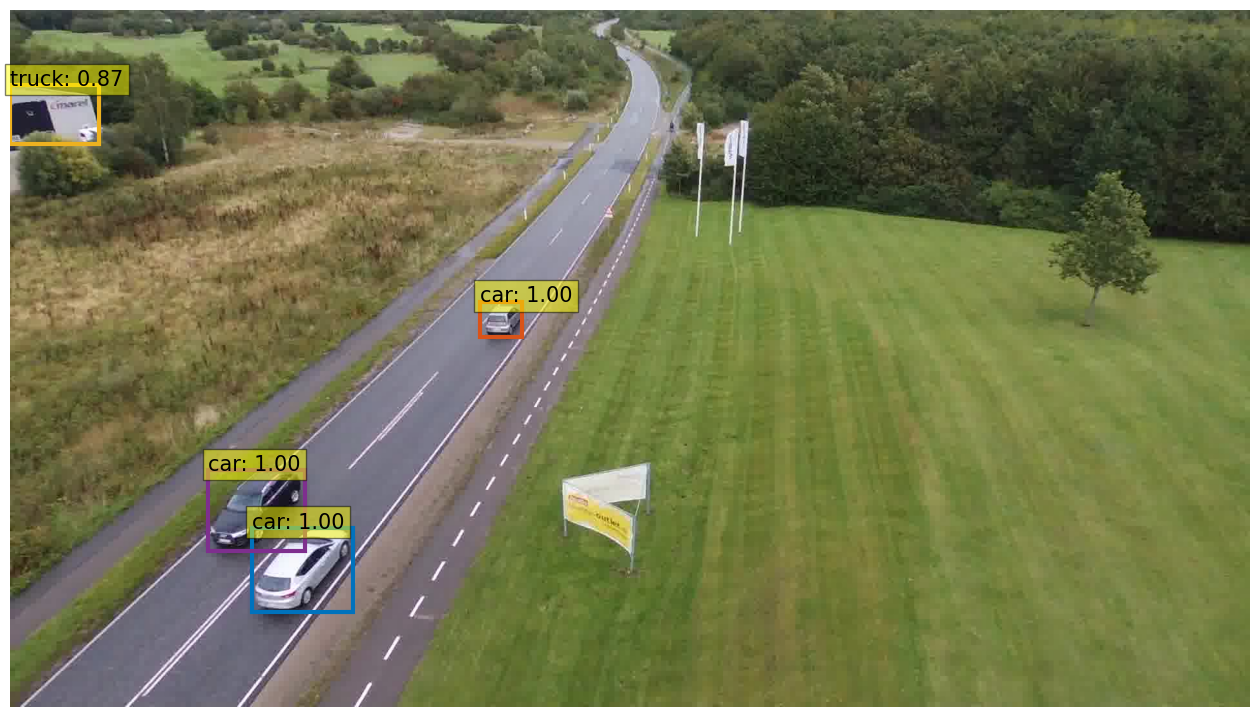

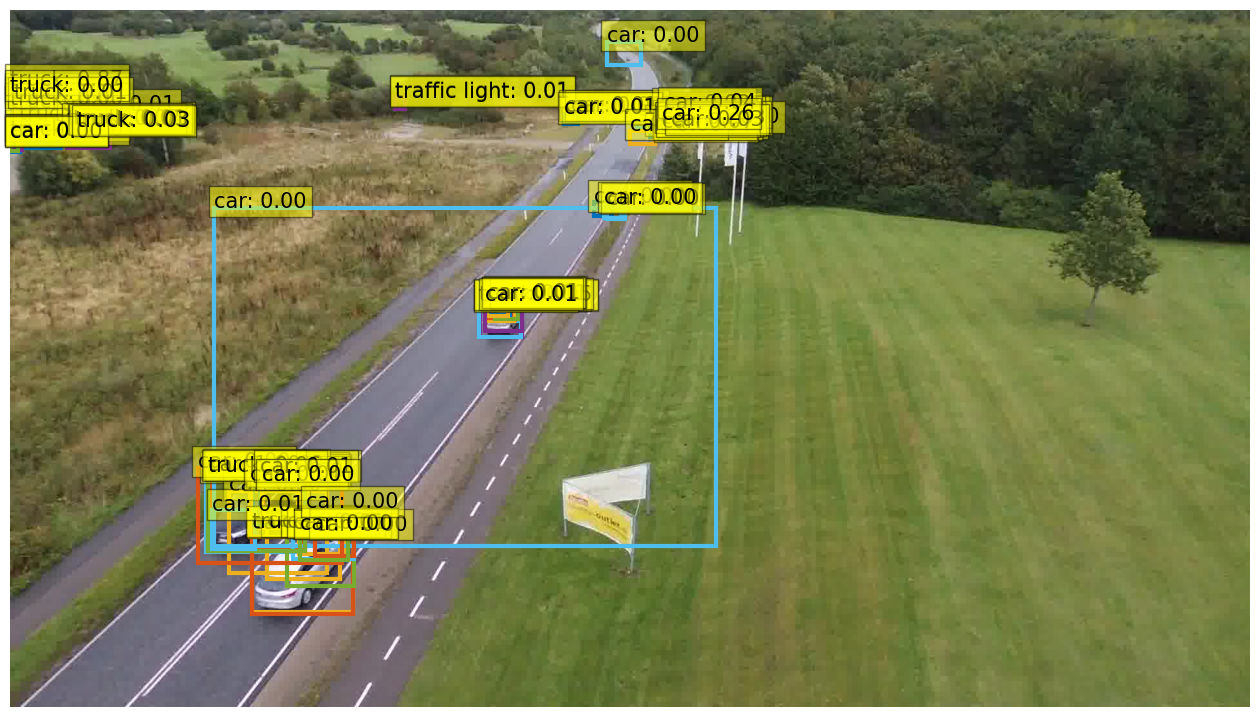

In [17]:
for threshold in [0.9, 0.7, 0.0]:

  probas_to_keep, bboxes_scaled = filter_bboxes_from_outputs(outputs,
                                                            threshold=threshold)

  plot_results(im, probas_to_keep, bboxes_scaled)

In [18]:
%cd /content/

!rm -rf detr
!git clone https://github.com/woctezuma/detr.git

%cd detr/

!git checkout finetune

[Errno 2] No such file or directory: '/content/'
/Users/orcanon/PycharmProjects/MMI725_Asssignment2


/Users/orcanon/.conda/envs/python3-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265 (from 1)
Receiving objects: 100% (265/265), 325.44 KiB | 1.52 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/Users/orcanon/PycharmProjects/MMI725_Asssignment2/detr
Already on 'finetune'
Your branch is up to date with 'origin/finetune'.


/Users/orcanon/.conda/envs/python3-env/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [19]:
# Get pretrained weights
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

In [20]:
# Choose whether to start indexing categories with 0 or with 1.
#
# NB: convention in COCO dataset is such that the 1st class (person) has ID n°1.
#
# NB²: this is why we chose to set to 1 the default value of `first_class_index`
# in `via2coco.convert()`.

first_class_index = 0

In [22]:
!pip install pycocotools

In [24]:
!pip install scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 6.3 MB/s eta 0:00:00a 0:00:01


In [41]:
%matplotlib inline
import pycocotools.coco as coco
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [50]:
%cd MMI725_Asssignment2/
%ls

/Users/orcanon/PycharmProjects/MMI725_Asssignment2
AU-AIR/              coco_conversion.py   detr_finetune.ipynb
README.md            coco_format/         eda_auair.py
auair_coco.json      detr/                split_dataset.py


In [51]:
dataDir='coco_format/'
dataType='train2017'
ann_path = Path("coco_format") / "annotations" / "custom_train.json"
print("Loading:", ann_path.resolve())
assert ann_path.exists(), f"Annotation file not found: {ann_path}"

coco = COCO(str(ann_path))
print(ann_path)

Loading: /Users/orcanon/PycharmProjects/MMI725_Asssignment2/coco_format/annotations/custom_train.json
loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
coco_format/annotations/custom_train.json


In [52]:
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [53]:
# === Display all categories and supercategories ===
cats = coco.loadCats(coco.getCatIds())
cat_names = [cat['name'] for cat in cats]
supercats = set([cat['supercategory'] for cat in cats])
print("Categories:", cat_names)
print("Super-categories:", supercats)

Categories: ['Human', 'Car', 'Truck', 'Van', 'Motorbike', 'Bicycle', 'Bus', 'Trailer']
Super-categories: {'object'}


In [55]:
# load and display image
catIds = coco.getCatIds(catNms=['Car']);
imgIds = coco.getImgIds(catIds=catIds );

Image n°16036
Image name: coco_format//train2017/frame_20190905112522_x_0000776.jpg


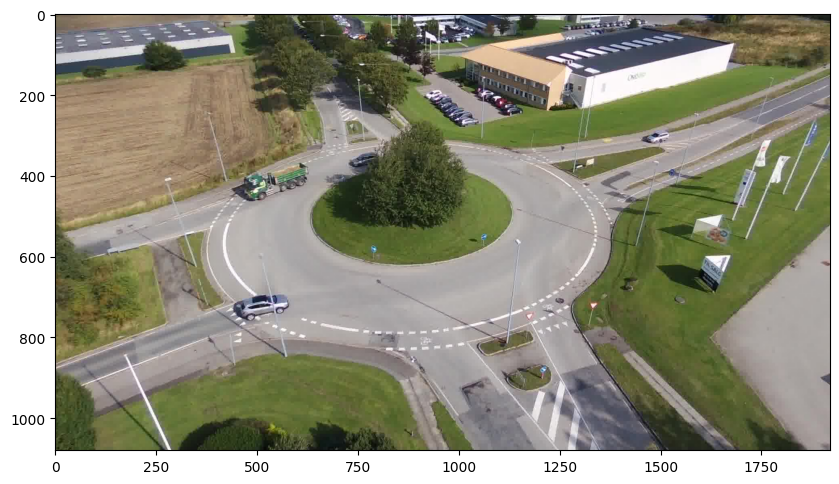

In [69]:
img_id = imgIds[np.random.randint(0,len(imgIds))]
print('Image n°{}'.format(img_id))

img = coco.loadImgs(img_id)[0]

img_name = '%s/%s/%s'%(dataDir, dataType, img['file_name'])
print('Image name: {}'.format(img_name))

I = io.imread(img_name)
plt.figure()
plt.imshow(I)

In [70]:
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

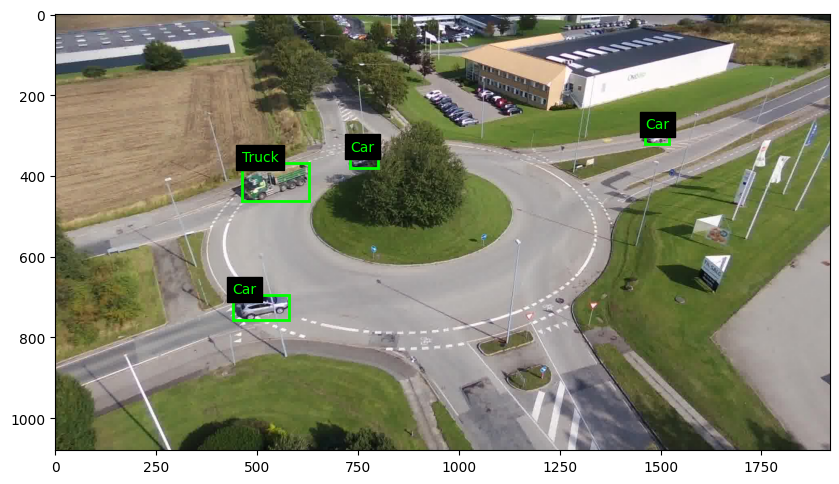

In [71]:
# load and display instance annotations
plt.imshow(I)
# Manually draw bounding boxes with category labels
from matplotlib.patches import Rectangle

for ann in anns:
    bbox = ann['bbox']  # [x, y, width, height]
    x, y, w, h = bbox
    cat_id = ann['category_id']
    cat_name = coco.loadCats(cat_id)[0]['name']

    # Draw rectangle
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
    plt.gca().add_patch(rect)

    # Draw label
    plt.text(x, y - 5, cat_name, color='lime', fontsize=10, backgroundcolor='black')


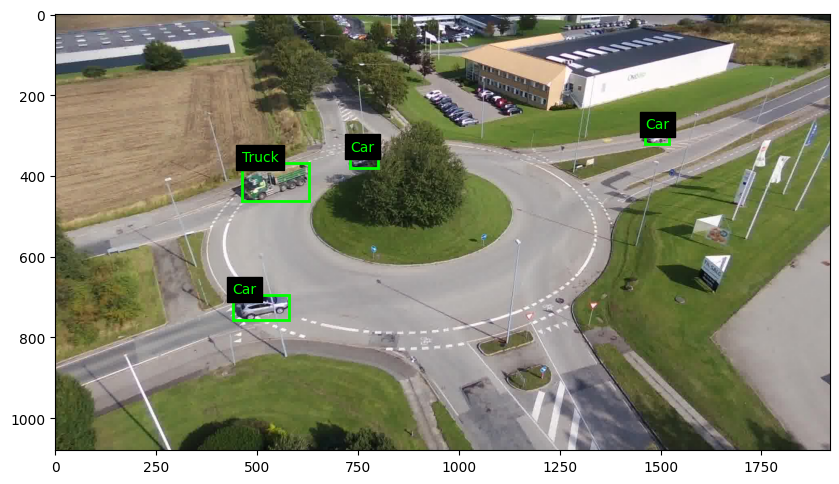

In [72]:
plt.imshow(I)
# Manually draw bounding boxes with category labels
from matplotlib.patches import Rectangle

for ann in anns:
    bbox = ann['bbox']  # [x, y, width, height]
    x, y, w, h = bbox
    cat_id = ann['category_id']
    cat_name = coco.loadCats(cat_id)[0]['name']

    # Draw rectangle
    rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
    plt.gca().add_patch(rect)

    # Draw label
    plt.text(x, y - 5, cat_name, color='lime', fontsize=10, backgroundcolor='black')
